### Soil Moisture in Portales, New Mexico

**Station Name:**  p038

**Location:**  Portales, New Mexico, USA

**Archive:** [UNAVCO](http://www.unavco.org)

**Ellipsoidal Coordinates:**

- Latitude: 34.14726 degrees

- Longitude: -103.40734 degrees

- Height: 1212.982 meters

[Station Page at UNAVCO](https://www.unavco.org/instrumentation/networks/status/nota/overview/P038)

[Google Maps Link](https://www.google.com/maps/place/34%C2%B008'50.1%22N+103%C2%B024'26.4%22W/@34.14725,-103.4073333,17z/data=!3m1!4b1!4m5!3m4!1s0x0:0x64e449f205085274!8m2!3d34.14725!4d-103.4073333) 

<p align="center">
<img src="../../../docs/_static/p038low.jpg" width="500"/>
</P>

P038 was a PBO site. The data from 2017 will be analyzed here as a test case. We will start by analyzing the data 
using the normal reflector height (GNSS-IR) processing. Then we will use those results to run the soil moisture code.

First, start by importing everything we need to run GNSS-IR:

In [1]:
import ipywidgets as widgets
import os

from pathlib import Path

from gnssrefl.utils import check_environment, set_environment, get_sys

notebook_dir = Path.cwd().parents[1]

# Making sure environment variables are set - this is required to run the gnssrefl code
exists = check_environment()
if exists == False:
    set_environment(refl_code=str(notebook_dir),
                    orbits=str(notebook_dir / "orbits"),
                    exe=str(notebook_dir / "exe"))
    
#If you are running this locally - make sure the items in the exe folder have execution permissions

# Set local variable of refl_code location
refl_code_loc = os.environ['REFL_CODE']
print("refl_code location:", refl_code_loc)

# import gnssrefl functions
from gnssrefl.installexe_cl import installexe
from gnssrefl.rinex2snr_cl import rinex2snr
from gnssrefl.gnssir_cl import gnssir
from gnssrefl.gnssir_input import make_gnssir_input
from gnssrefl.daily_avg_cl import daily_avg
from gnssrefl.vwc_input import vwc_input
from gnssrefl.quickPhase import quickphase
from gnssrefl.vwc import vwc

environment variable ORBITS set to path /Users/kellyenloe/EarthScope/gnssrefl_tim/notebooks/orbits 
environment variable REFL_CODE set to path /Users/kellyenloe/EarthScope/gnssrefl_tim/notebooks 
environment variable EXE set to path /Users/kellyenloe/EarthScope/gnssrefl_tim/notebooks/exe
refl_code location: /Users/kellyenloe/EarthScope/gnssrefl_tim/notebooks


#### Step 1: GNSS-IR
Begin by generating the SNR files. Although typically PBO sites do not have L2C 
data in their low-rate RINEX files, UNAVCO is providing these data in the "special" archive section
so that people can test out this code.

In [2]:
# Set station, year, doy, and doy_end as variables so they can be used throughout the rest of this example
station = 'p038'
year=2017
doy=1
doy_end=365

rinex2snr(station=station, year=year, doy=doy, doy_end=doy_end, archive='special')

p038  year: 2017  doy: 1 from:  special
Requested a GPS only nav file
Nav file exists online
Orbit file:  /Users/kellyenloe/EarthScope/gnssrefl_tim/notebooks/orbits/2017/nav/auto0010.17n
Seeking permission from Earthscope to use their archive
To complete the SSO authorization, please visit the following URL in a browser of your choice:
            https://login.earthscope.org/activate?user_code=KZMT-STLN
            


SUCCESS: SNR file was created 
 /Users/kellyenloe/EarthScope/gnssrefl_tim/notebooks/2017/snr/p038/p0380010.17.snr66
p038  year: 2017  doy: 2 from:  special
Requested a GPS only nav file
Nav file exists online
Orbit file:  /Users/kellyenloe/EarthScope/gnssrefl_tim/notebooks/orbits/2017/nav/auto0020.17n
Seeking permission from Earthscope to use their archive


SUCCESS: SNR file was created 
 /Users/kellyenloe/EarthScope/gnssrefl_tim/notebooks/2017/snr/p038/p0380020.17.snr66
p038  year: 2017  doy: 3 from:  special
Requested a GPS only nav file
Nav file exists online
Orbit f

If you want to remind yourself why the L2C data are superior to the L1 data recorded for this receiver, use <code>quickLook</code>. You will need to import it from gnssrefl.

The analysis parameters are set up with <code>make_gnssir_input</code>. We only need the L2C data, so have set the parameter accordingly.

In [3]:
make_gnssir_input(station, l2c=True)

Assume you want to use the UNR database.
Using standard frequency choices.
writing out to: /Users/kellyenloe/EarthScope/gnssrefl_tim/notebooks/input/p038.json


Now we run <code>gnssir</code>. This will be needed for estimate a priori reflector heights for the soil moisture code.

In [4]:
gnssir(station, year, doy, doy_end=doy_end)

{'station': 'p038', 'lat': 34.147255321, 'lon': -103.40733834, 'ht': 1212.9696282, 'minH': 0.5, 'maxH': 8.0, 'e1': 5.0, 'e2': 25.0, 'NReg': [0.5, 8.0], 'PkNoise': 2.8, 'polyV': 4, 'pele': [5, 30], 'ediff': 2.0, 'desiredP': 0.005, 'azval2': [0, 360], 'freqs': [20], 'reqAmp': [5.0], 'refraction': True, 'overwriteResults': True, 'seekRinex': False, 'wantCompression': False, 'plt_screen': False, 'onesat': None, 'screenstats': False, 'pltname': 'p038_lsp.png', 'delTmax': 75.0, 'gzip': False, 'ellist': []}
refraction file exists
requested frequencies  [20]
Using the New Way of Selecting Arcs
Augmented elevation angle list []
Requested azimuths:  [0, 360]
Using azimuths:  [0, 360]
A station specific refraction output file will be written to  /Users/kellyenloe/EarthScope/gnssrefl_tim/notebooks/input/p038_refr.txt
found  /Users/kellyenloe/EarthScope/gnssrefl_tim/notebooks/input/
The large refraction file should be stored here: /Users/kellyenloe/EarthScope/gnssrefl_tim/notebooks/input/gpt_1wA.pi

#### Step 2: Soil Moisture

[Please read the soil moisture user manual.](https://github.com/kristinemlarson/gnssrefl/blob/master/docs/README_vwc.md) It is very short and has a lot of tips that will save you time.

We need a list of satellite tracks to use:

In [5]:
# remember you can see what parameters are accepted by running: vwc_input?

vwc_input(station, 2017)

Minimum number of tracks required  100
Using L2C satellite list for December 31 on  2017
>>>> Apriori RH file written to  /Users/kellyenloe/EarthScope/gnssrefl_tim/notebooks/input/p038_phaseRH.txt


This creates a file that is stored in $REFL_CODE/input/p038_phaseRH.txt

Now we estimate the phase for each satellite track on each day:


In [6]:
quickphase(station, year, doy, doy_end=doy_end)

Saving phase file to: /Users/kellyenloe/EarthScope/gnssrefl_tim/notebooks/2017/phase/p038/001.txt
Using:  /Users/kellyenloe/EarthScope/gnssrefl_tim/notebooks/input/p038_phaseRH.txt
Analyzing Frequency  20  Year  2017  Day of Year  1
Saving phase file to: /Users/kellyenloe/EarthScope/gnssrefl_tim/notebooks/2017/phase/p038/002.txt
Using:  /Users/kellyenloe/EarthScope/gnssrefl_tim/notebooks/input/p038_phaseRH.txt
Analyzing Frequency  20  Year  2017  Day of Year  2
Saving phase file to: /Users/kellyenloe/EarthScope/gnssrefl_tim/notebooks/2017/phase/p038/003.txt
Using:  /Users/kellyenloe/EarthScope/gnssrefl_tim/notebooks/input/p038_phaseRH.txt
Analyzing Frequency  20  Year  2017  Day of Year  3
Saving phase file to: /Users/kellyenloe/EarthScope/gnssrefl_tim/notebooks/2017/phase/p038/004.txt
Using:  /Users/kellyenloe/EarthScope/gnssrefl_tim/notebooks/input/p038_phaseRH.txt
Analyzing Frequency  20  Year  2017  Day of Year  4
Saving phase file to: /Users/kellyenloe/EarthScope/gnssrefl_tim/note

Finally, convert the phase to volumetric water content.

This will result in 4 plots:
1. Phase results in geographic coordinates
2. Daily average phase
3. Model inputs
4. Final Results

These will all be saved in $REFL_CODE/Files

Requested frequency:  20
Total phase measurements for this frequency:  13462
13462  number of rows
Using:  /Users/kellyenloe/EarthScope/gnssrefl_tim/notebooks/input/p038_phaseRH.txt
p038_tmp.txt /Users/kellyenloe/EarthScope/gnssrefl_tim/notebooks/input/p038_phaseRH.txt
No average , so no QC. You should iterate.
No average , so no QC. You should iterate.
No average , so no QC. You should iterate.
No average , so no QC. You should iterate.
No average , so no QC. You should iterate.
No average , so no QC. You should iterate.
No average , so no QC. You should iterate.
No average , so no QC. You should iterate.
No average , so no QC. You should iterate.
No average , so no QC. You should iterate.
No average , so no QC. You should iterate.
No average , so no QC. You should iterate.
No average , so no QC. You should iterate.
No average , so no QC. You should iterate.
No average , so no QC. You should iterate.
No average , so no QC. You should iterate.
No average , so no QC. You should iterate.

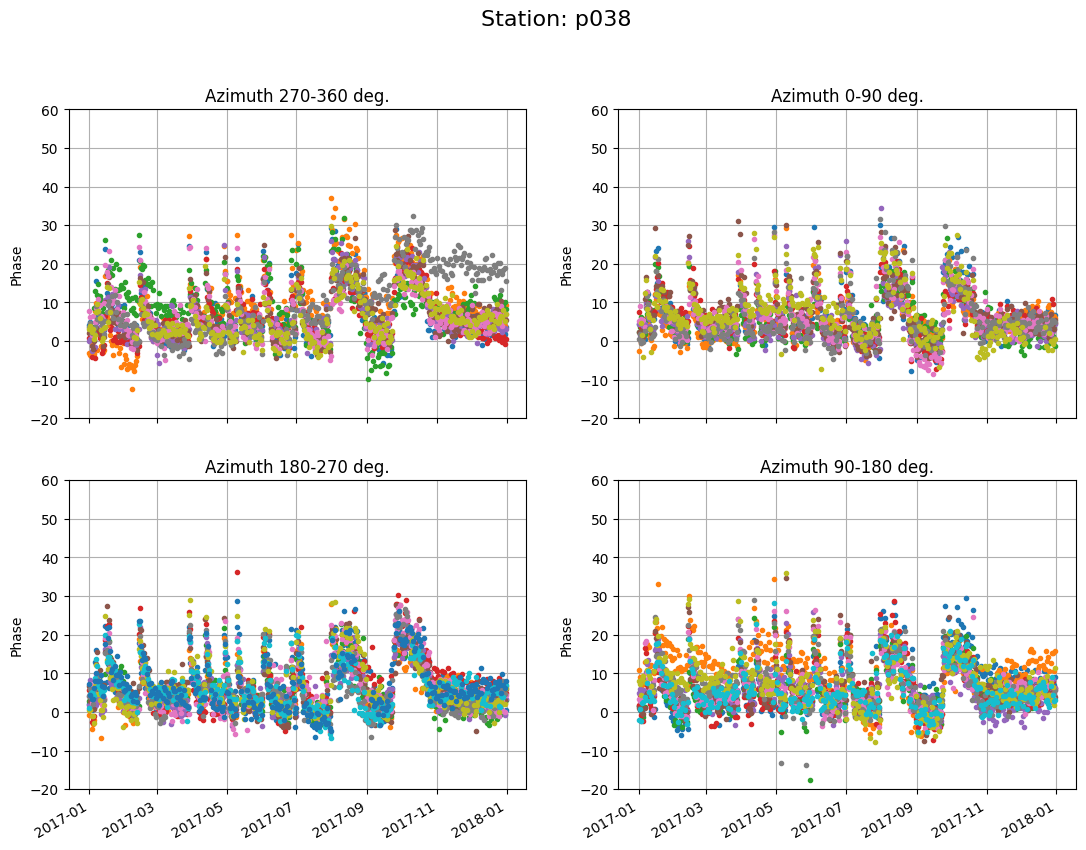

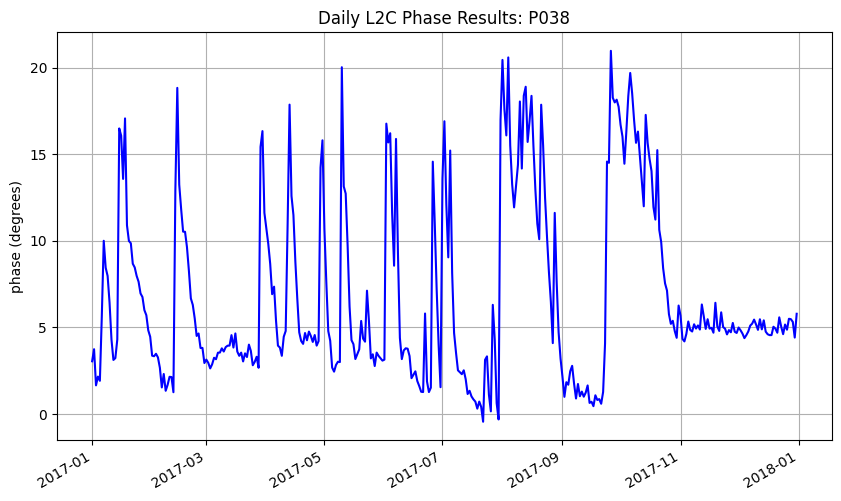

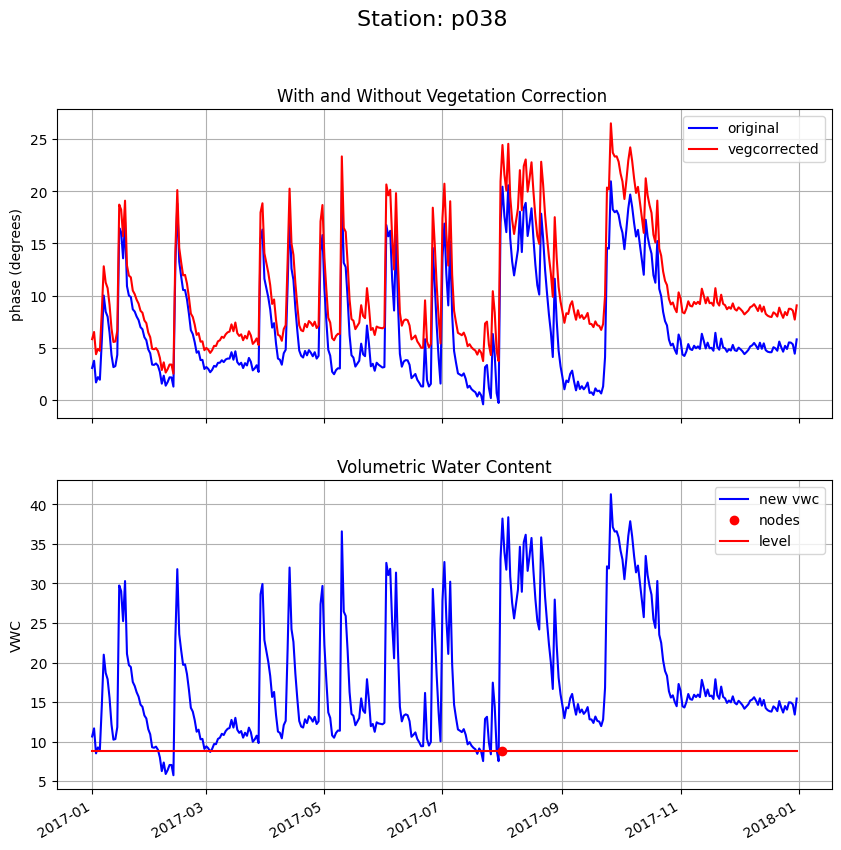

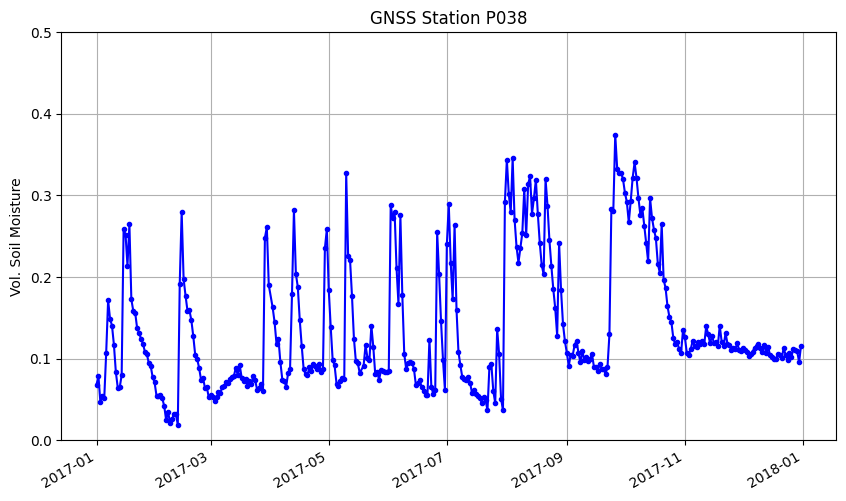

>>> VWC results being written to  /Users/kellyenloe/EarthScope/gnssrefl_tim/notebooks/Files/p038/p038_vwc.txt


In [7]:
vwc(station, year)

Thank you to Naoya Kadota for test driving this use case.